In [1]:
import sys
sys.path.append('..')

import numpy as np
from src.helpers import load_csv_data, standardize, flatten_jet_features, predict_labels, create_csv_submission, get_jet_indexes, jet_indexes, compute_accuracy
from src.linear.implementations import ridge_regression
from src.split import split_data
from src.polynomials import build_poly_matrix_vandermonde, build_poly_matrix_quadratic
from src.plots import plot_train_test, plot_poly_degree
from src.linear.loss import compute_loss
from src.k_fold import cross_validation, build_k_indices
import time

%reload_ext autoreload
%autoreload 2

In [2]:
# Import data
y, x_raw, ids = load_csv_data('../data/train.csv')

## Plain ridge regression

In [81]:
x, mean_x, std_x = standardize(x_raw)
tx = np.c_[np.ones((y.shape[0], 1)), x]

In [75]:
ratio = 0.8
tx_train, y_train, tx_test, y_test = split_data(tx, y, ratio)

In [76]:
loss, w = ridge_regression(y_train, tx_train, 0.01)

In [77]:
y_pred = predict_labels(w, tx_test, mode='linear')

In [78]:
(y_pred == y_test).sum() / y_test.shape[0]

0.68992

## Ridge regression with flattened jet features

In [16]:
x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = np.c_[np.ones((y.shape[0], 1)), x]

In [17]:
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

In [18]:
loss, w = ridge_regression(y_train, tx_train, 0.01)

In [19]:
y_pred = predict_labels(w, tx_test, mode='linear')

In [20]:
(y_pred == y_test).sum() / y_test.shape[0]

0.70966

## Ridge regression with flattened jet features and polynomial degree

In [13]:
x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = build_poly_matrix_vandermonde(x, 12)

In [14]:
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

In [15]:
loss, w = ridge_regression(y_train, tx_train, 0.0001)

In [16]:
y_pred = predict_labels(w, tx_test, mode='linear')

In [17]:
(y_pred == y_test).sum() / y_test.shape[0]

0.79616

Result with lambda = 0.0001, degree = 12 => 0.79616

In [ ]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')
y_pred = predict_labels(w, tx_test, mode='linear')
create_csv_submission(ids, y_pred, '../submissions/10-24.22-32.csv')

## Ridge regression with different sets

In [45]:
degree = 2
ratio = 0.8
lambda_ = 0.0001

x_train, y_train, x_test, y_test = split_data(x_raw, y, ratio)

train_jet_indexes= get_jet_indexes(x_train)
test_jet_indexes = get_jet_indexes(x_test)

In [46]:
ws = []
accuracies = []

y_pred = np.zeros((x_test.shape[0], 1))

for i in train_jet_indexes:
    
    tx_train_raw = x_train[train_jet_indexes[i]]
    tx_test_raw = x_test[test_jet_indexes[i]]
    
    tx_train_std = standardize(tx_train_raw)[0]
    tx_test_std = standardize(tx_test_raw)[0]
    
    tx_train_rem = np.delete(tx_train_std, jet_indexes[i], axis=1)
    tx_test_rem = np.delete(tx_test_std, jet_indexes[i], axis=1)
    
    tx_train = build_poly_matrix_vandermonde(tx_train_rem, degree)
    tx_test = build_poly_matrix_vandermonde(tx_test_rem, degree)
    
    loss, w = ridge_regression(y_train[train_jet_indexes[i]], tx_train, lambda_)
    
    y_pred[test_jet_indexes[i]] = predict_labels(w, tx_test, mode='linear')
    ws.append(w)

In [47]:
tot_accuracy = (y_pred == y_test).sum() / (y_test.shape[0])
tot_accuracy

0.57474

With degree 12, lambda = 0.001 => test accuracy = 0.710

In [9]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')
tx_sub_split, y_sub_split, ids_split = jet_split(x_sub_raw, y_sub, ids_sub, degree)

In [10]:
y_split_pred = [predict_labels(ws[i], x, mode='linear') for i, x in enumerate(tx_sub_split)]

In [12]:
y_split_cat = np.concatenate(y_split_pred)
ids_split_cat = np.concatenate(ids_split)
create_csv_submission(ids_split_cat, y_split_cat, '../submissions/10-24.21-37.csv')

## Ridge regression with lambda grid_search

In [3]:
def ridge_regression_lambda_search(x, y, lambdas, degree, ratio):

    x = flatten_jet_features(x_raw)
    x, mean_x, std_x = standardize(x)
    tx = build_poly_matrix_vandermonde(x, degree)

    tx_train, y_train, tx_test, y_test = split_data(tx, y, ratio)

    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, lambda_ in enumerate(lambdas):

        tr_loss, w = ridge_regression(y_train, tx_train, lambda_)
        te_loss = compute_loss(y_test, tx_test, w)
        
        tr_acc = compute_accuracy(tx_train, w, y_train, mode='linear')
        te_acc = compute_accuracy(tx_test, w, y_test, mode='linear')

        rmse_tr.append(np.math.sqrt(2 * tr_loss))
        rmse_te.append(np.math.sqrt(2 * te_loss))
        acc_tr.append(tr_acc)
        acc_te.append(te_acc)
        ws.append(w)

        print("proportion={p}, degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    plot_train_test(acc_tr, acc_te, lambdas, degree)
    return ws, rmse_tr, rmse_te

proportion=0.8, degree=12, lambda=0.000010, Training RMSE=0.756, Testing RMSE=10.606
proportion=0.8, degree=12, lambda=0.000023, Training RMSE=0.760, Testing RMSE=8.879
proportion=0.8, degree=12, lambda=0.000052, Training RMSE=0.765, Testing RMSE=4.703
proportion=0.8, degree=12, lambda=0.000118, Training RMSE=0.770, Testing RMSE=1.670
proportion=0.8, degree=12, lambda=0.000268, Training RMSE=0.774, Testing RMSE=7.912
proportion=0.8, degree=12, lambda=0.000611, Training RMSE=0.778, Testing RMSE=13.023
proportion=0.8, degree=12, lambda=0.001389, Training RMSE=0.782, Testing RMSE=15.666
proportion=0.8, degree=12, lambda=0.003162, Training RMSE=0.789, Testing RMSE=15.701
proportion=0.8, degree=12, lambda=0.007197, Training RMSE=0.802, Testing RMSE=10.731
proportion=0.8, degree=12, lambda=0.016379, Training RMSE=0.820, Testing RMSE=1.235
proportion=0.8, degree=12, lambda=0.037276, Training RMSE=0.841, Testing RMSE=10.504
proportion=0.8, degree=12, lambda=0.084834, Training RMSE=0.860, Testi

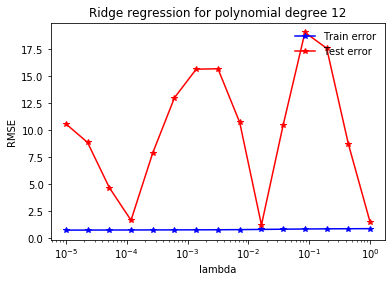

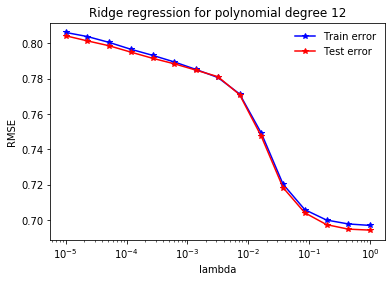

In [4]:
lambdas = np.logspace(-5, 0, 15)
degree = 12
ratio = 0.8

ws, rmse_tr, rmse_te = ridge_regression_lambda_search(x_raw, y, lambdas, degree, ratio)

In [3]:
def ridge_regression_degree_search(x, y, lambda_, degrees, ratio):

    x = flatten_jet_features(x_raw)
    x, mean_x, std_x = standardize(x)

    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, degree in enumerate(degrees):
        
        tx = build_poly_matrix_vandermonde(x, degree)
        tx_train, y_train, tx_test, y_test = split_data(tx, y, ratio)

        tr_loss, w = ridge_regression(y_train, tx_train, lambda_)
        te_loss = compute_loss(y_test, tx_test, w)
        
        tr_acc = compute_accuracy(tx_train, w, y_train, mode='linear')
        te_acc = compute_accuracy(tx_test, w, y_test, mode='linear')

        rmse_tr.append(np.math.sqrt(2 * tr_loss))
        rmse_te.append(np.math.sqrt(2 * te_loss))
        acc_tr.append(tr_acc)
        acc_te.append(te_acc)
        ws.append(w)

        print("proportion={p}, degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_poly_degree(rmse_tr, rmse_te, degrees, lambda_)
    plot_poly_degree(acc_tr, acc_te, degrees, lambda_)
    return ws, rmse_tr, rmse_te

proportion=0.8, degree=0, lambda=0.000100, Training RMSE=0.949, Testing RMSE=0.950
proportion=0.8, degree=1, lambda=0.000100, Training RMSE=0.844, Testing RMSE=0.846
proportion=0.8, degree=2, lambda=0.000100, Training RMSE=0.830, Testing RMSE=0.830
proportion=0.8, degree=3, lambda=0.000100, Training RMSE=0.818, Testing RMSE=0.820
proportion=0.8, degree=4, lambda=0.000100, Training RMSE=0.802, Testing RMSE=0.804
proportion=0.8, degree=5, lambda=0.000100, Training RMSE=0.789, Testing RMSE=0.790
proportion=0.8, degree=6, lambda=0.000100, Training RMSE=0.783, Testing RMSE=0.788
proportion=0.8, degree=7, lambda=0.000100, Training RMSE=0.783, Testing RMSE=0.837
proportion=0.8, degree=8, lambda=0.000100, Training RMSE=0.778, Testing RMSE=0.876
proportion=0.8, degree=9, lambda=0.000100, Training RMSE=0.774, Testing RMSE=0.902
proportion=0.8, degree=10, lambda=0.000100, Training RMSE=0.774, Testing RMSE=1.476
proportion=0.8, degree=11, lambda=0.000100, Training RMSE=0.770, Testing RMSE=7.125
pr

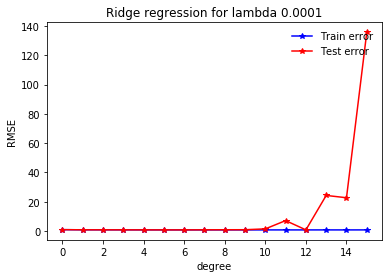

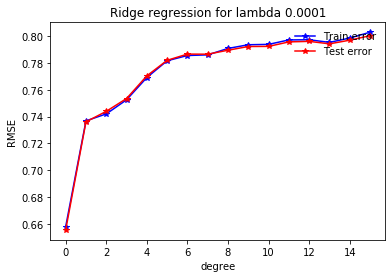

In [4]:
lambda_ = 0.0001
degrees = range(16)
ratio = 0.8

ws, rmse_tr, rmse_te = ridge_regression_degree_search(x_raw, y, lambda_, degrees, ratio)

The best combination seems to be with lambda = 0.0001 and degree = 15

In [16]:
lambda_ = 0.00001
degree = 5

x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = build_poly_matrix_vandermonde(x, degree)
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

loss, w = ridge_regression(y_train, tx_train, lambda_)

In [17]:
y_pred = predict_labels(w, tx_test, mode='linear')
(y_pred == y_test).sum() / y_test.shape[0]

0.78428

In [18]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')

x_sub = flatten_jet_features(x_sub_raw)
x_sub, mean_x, std_x = standardize(x_sub)
tx_sub = build_poly_matrix_vandermonde(x_sub, degree)

In [19]:
y_sub = predict_labels(w, tx_sub, mode='linear')

In [20]:
create_csv_submission(ids_sub, y_sub, '../submissions/10-25.00-44.csv')

## Ridge regression with cross validation

In [40]:
def ridge_regression_cross_degree_search(x, y, lambda_, degrees, k):

    x = flatten_jet_features(x)
    x, mean_x, std_x = standardize(x)
    
    k_indices = build_k_indices(y, k, 1)

    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, degree in enumerate(degrees):
        
        tr_loss, te_loss, tr_acc, te_acc = cross_validation(y, x, k_indices, k, lambda_, degree, ridge_regression)


        rmse_tr.append(np.math.sqrt(2 * tr_loss))
        rmse_te.append(np.math.sqrt(2 * te_loss))
        acc_tr.append(tr_acc)
        acc_te.append(te_acc)
        # ws.append(w)

        print("degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_poly_degree(rmse_tr, rmse_te, degrees, lambda_)
    plot_poly_degree(acc_tr, acc_te, degrees, lambda_)
    return ws, rmse_tr, rmse_te

In [ ]:
lambda_ = 1e-3
degrees = range(15)
k = 5 
ws, rmse_tr, rmse_te = ridge_regression_cross_degree_search(x_raw, y, lambda_, degrees, 5)

## Ridge regression with cross validation on different sets

In [48]:
def ridge_regression_cross_degree_search_sets(x, y, lambda_, degrees, k):
    
    x_jet_indexes = get_jet_indexes(x)
    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, degree in enumerate(degrees):
        
        ws = []
        te_accs = []
        tr_accs = []
        te_losses = []
        tr_losses = []

        for i in x_jet_indexes:

            tx_std = standardize(x[x_jet_indexes[i]])[0]
            tx = np.delete(tx_std, jet_indexes[i], axis=1)
            y_i = y[x_jet_indexes[i]]
            
            k_indices = build_k_indices(y_i, k, 1)
            
            tr_loss, te_loss, tr_acc, te_acc = \
                cross_validation(y_i, tx, k_indices, k, lambda_, degree, ridge_regression)

            # ws.append(w)
            te_accs.append(te_acc * x[x_jet_indexes[i]].shape[0])
            tr_accs.append(tr_acc * x[x_jet_indexes[i]].shape[0])
            te_losses.append(te_loss * x[x_jet_indexes[i]].shape[0])
            tr_losses.append(tr_loss * x[x_jet_indexes[i]].shape[0])
            
        rmse_tr.append(np.math.sqrt(2 * sum(tr_losses) / x.shape[0]))
        rmse_te.append(np.math.sqrt(2 * sum(te_losses) / x.shape[0]))
        acc_tr.append(sum(tr_accs) / x.shape[0])
        acc_te.append(sum(te_accs) / x.shape[0])

        print("degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_poly_degree(rmse_tr, rmse_te, degrees, lambda_)
    plot_poly_degree(acc_tr, acc_te, degrees, lambda_)
    
    return ws, rmse_tr, rmse_te

degree=0, lambda=0.000010, Training RMSE=1.367, Testing RMSE=1.367
degree=1, lambda=0.000010, Training RMSE=1.286, Testing RMSE=2.541
degree=2, lambda=0.000010, Training RMSE=1.273, Testing RMSE=4.747
degree=3, lambda=0.000010, Training RMSE=1.265, Testing RMSE=16.089
degree=4, lambda=0.000010, Training RMSE=1.255, Testing RMSE=33.325
degree=5, lambda=0.000010, Training RMSE=1.246, Testing RMSE=72.251
degree=6, lambda=0.000010, Training RMSE=1.243, Testing RMSE=323.853
degree=7, lambda=0.000010, Training RMSE=1.241, Testing RMSE=2495.046


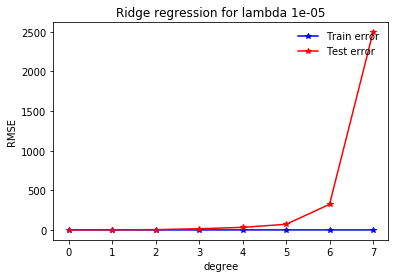

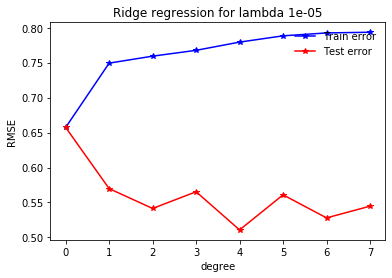

In [50]:
lambda_ = 1e-5
degrees = range(8)
k = 5

ws, rmse_tr, rmse_te = ridge_regression_cross_degree_search_sets(x_raw, y, lambda_, degrees, 5)

In [6]:
def ridge_regression_cross_lambda_search_sets(x, y, lambdas, k):
    
    x_jet_indexes = get_jet_indexes(x)
    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, lambda_ in enumerate(lambdas):
        
        ws = []
        te_accs = []
        tr_accs = []
        te_losses = []
        tr_losses = []

        for i in x_jet_indexes:

            tx_std = standardize(x[x_jet_indexes[i]])[0]
            tx_del = np.delete(tx_std, jet_indexes[i], axis=1)
            tx = build_poly_matrix_quadratic(tx_del)
            y_i = y[x_jet_indexes[i]]
            
            k_indices = build_k_indices(y_i, k, 1)
            
            tr_loss, te_loss, tr_acc, te_acc = \
                cross_validation(y_i, tx, k_indices, k, lambda_, ridge_regression)

            # ws.append(w)
            te_accs.append(te_acc * x[x_jet_indexes[i]].shape[0])
            tr_accs.append(tr_acc * x[x_jet_indexes[i]].shape[0])
            te_losses.append(te_loss * x[x_jet_indexes[i]].shape[0])
            tr_losses.append(tr_loss * x[x_jet_indexes[i]].shape[0])
            
        rmse_tr.append(np.math.sqrt(2 * sum(tr_losses) / x.shape[0]))
        rmse_te.append(np.math.sqrt(2 * sum(te_losses) / x.shape[0]))
        acc_tr.append(sum(tr_accs) / x.shape[0])
        acc_te.append(sum(te_accs) / x.shape[0])

        print("lambda={l:.6f}, Training accuracy={tr:.3f}, Testing accuracy={te:.3f}".format(
                   l=lambda_, tr=acc_tr[ind], te=acc_te[ind]))

    plot_train_test(rmse_tr, rmse_te, lambdas, 2)
    plot_train_test(acc_tr, acc_te, lambdas, 2)
    
    return ws, rmse_tr, rmse_te

lambda=0.000010, Training accuracy=0.778, Testing accuracy=0.777
lambda=0.000036, Training accuracy=0.773, Testing accuracy=0.773
lambda=0.000129, Training accuracy=0.769, Testing accuracy=0.768
lambda=0.000464, Training accuracy=0.764, Testing accuracy=0.764
lambda=0.001668, Training accuracy=0.759, Testing accuracy=0.759
lambda=0.005995, Training accuracy=0.750, Testing accuracy=0.750
lambda=0.021544, Training accuracy=0.725, Testing accuracy=0.725
lambda=0.077426, Training accuracy=0.713, Testing accuracy=0.713
lambda=0.278256, Training accuracy=0.707, Testing accuracy=0.706
lambda=1.000000, Training accuracy=0.702, Testing accuracy=0.702


([],
 [1.2532260594879745,
  1.2601822829249005,
  1.267067714737374,
  1.2735861112601283,
  1.27910651176433,
  1.2848478433916235,
  1.2936473167554279,
  1.3086028243379844,
  1.3258026665514997,
  1.338938973825146],
 [1.340481572139337,
  1.2707849724989222,
  1.2691380926468474,
  1.2766223519242017,
  1.2820528335311139,
  1.2872663497977792,
  1.29505375705348,
  1.3090949703949921,
  1.325954506274377,
  1.339010570881045])

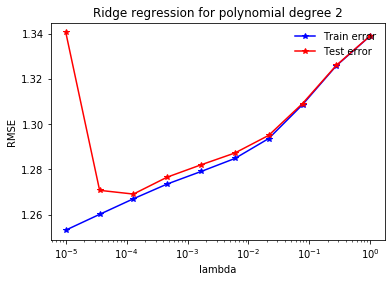

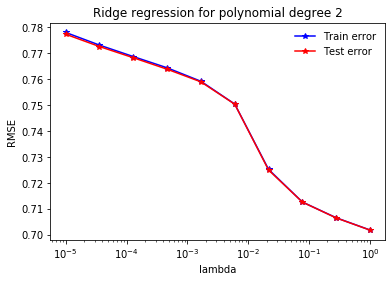

In [8]:
lambdas = np.logspace(-5, 0, 10)
k = 5

ridge_regression_cross_lambda_search_sets(x_raw, y, lambdas, k)

In [10]:
lambda_ = 0.00001

x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = build_poly_matrix_quadratic(x)
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

loss, w = ridge_regression(y_train, tx_train, lambda_)

In [11]:
y_pred = predict_labels(w, tx_test, mode='linear')
(y_pred == y_test).sum() / y_test.shape[0]

0.7719

In [5]:
ws = []
x_jet_indexes = get_jet_indexes(x_raw)
k = 5
lambda_ = 1e-5

for i in x_jet_indexes:

    tx_std = standardize(x_raw[x_jet_indexes[i]])[0]
    tx_del = np.delete(tx_std, jet_indexes[i], axis=1)
    tx = build_poly_matrix_quadratic(tx_del)
    y_i = y[x_jet_indexes[i]]

    k_indices = build_k_indices(y_i, k, 1)

    w, tr_loss, te_loss, tr_acc, te_acc = \
        cross_validation(y_i, tx, k_indices, k, lambda_, ridge_regression)

    ws.append(w)

In [6]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')
x_sub_jet_indexes = get_jet_indexes(x_sub_raw)

In [8]:
for i, w in enumerate(ws):
    tx_sub_std_i = standardize(x_sub_raw[x_sub_jet_indexes[i]])[0]
    tx_sub_del_i = np.delete(tx_sub_std_i, jet_indexes[i], axis=1)
    tx_sub_i = build_poly_matrix_quadratic(tx_sub_del_i)
    print(tx_sub_i.shape)
    # y_sub[x_sub_jet_indexes[i]] = predict_labels(w, tx_sub, mode='linear')
    
create_csv_submission(ids_sub, y_sub, '../submissions/10-26.16-42.csv')

(227458, 420)
(175338, 552)


MemoryError: Unable to allocate array with shape (165442, 930) and data type float64